# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from yellowbrick.target import BalancedBinningReference
from yellowbrick.regressor import PredictionError, ResidualsPlot


import os
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.facecolor']='#999999'

In [2]:
df = pd.read_csv('prepared_data.csv')
df.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


# Data Preparation

Let's drop the columns that will not affect the price prediction.

In [3]:
df.drop(["name", "host_id"], axis = 1, inplace = True)

In [8]:
from sklearn.cluster import KMeans


### Cluster Area by Price 

In [38]:
price = df[['neighbourhood', 'price', 'latitude', 'longitude']]
price = price.groupby('neighbourhood').agg(price = ('price', 'sum'),
                                        latitude = ('latitude', max), longitude = ('longitude', max)).reset_index()
price

,neighbourhood,price,latitude,longitude
0,Allerton,180.039188,40.87268,-73.84669
1,Arden Heights,16.761900,40.56033,-74.17388
2,Arrochar,91.924167,40.59809,-74.06476
3,Arverne,372.749152,40.59910,-73.78665
4,Astoria,4044.268584,40.77705,-73.90393
...,...,...,...,...
216,Windsor Terrace,751.026718,40.66063,-73.97237
217,Woodhaven,360.343110,40.69907,-73.84611
218,Woodlawn,44.597943,40.90406,-73.86286
219,Woodrow,6.552508,40.53884,-74.19826


In [39]:

# Selecting the relevant columns for clustering
X = price[['price']].values

# Applying K-means clustering
k = 3  # Number of clusters you want to create
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Adding cluster labels to the dataframe
price['Cluster'] = kmeans.labels_

# Printing the resulting clusters
price[['neighbourhood', 'price', 'Cluster']]

,neighbourhood,price,Cluster
0,Allerton,180.039188,0
1,Arden Heights,16.761900,0
2,Arrochar,91.924167,0
3,Arverne,372.749152,0
4,Astoria,4044.268584,2
...,...,...,...
216,Windsor Terrace,751.026718,0
217,Woodhaven,360.343110,0
218,Woodlawn,44.597943,0
219,Woodrow,6.552508,0


* 0 cluster belongs to lowest rate
* 1 cluster belongs to moderate rate
* 2 cluster belongs to highest rates. 
* In the folium map the size of the circle defines the price of area

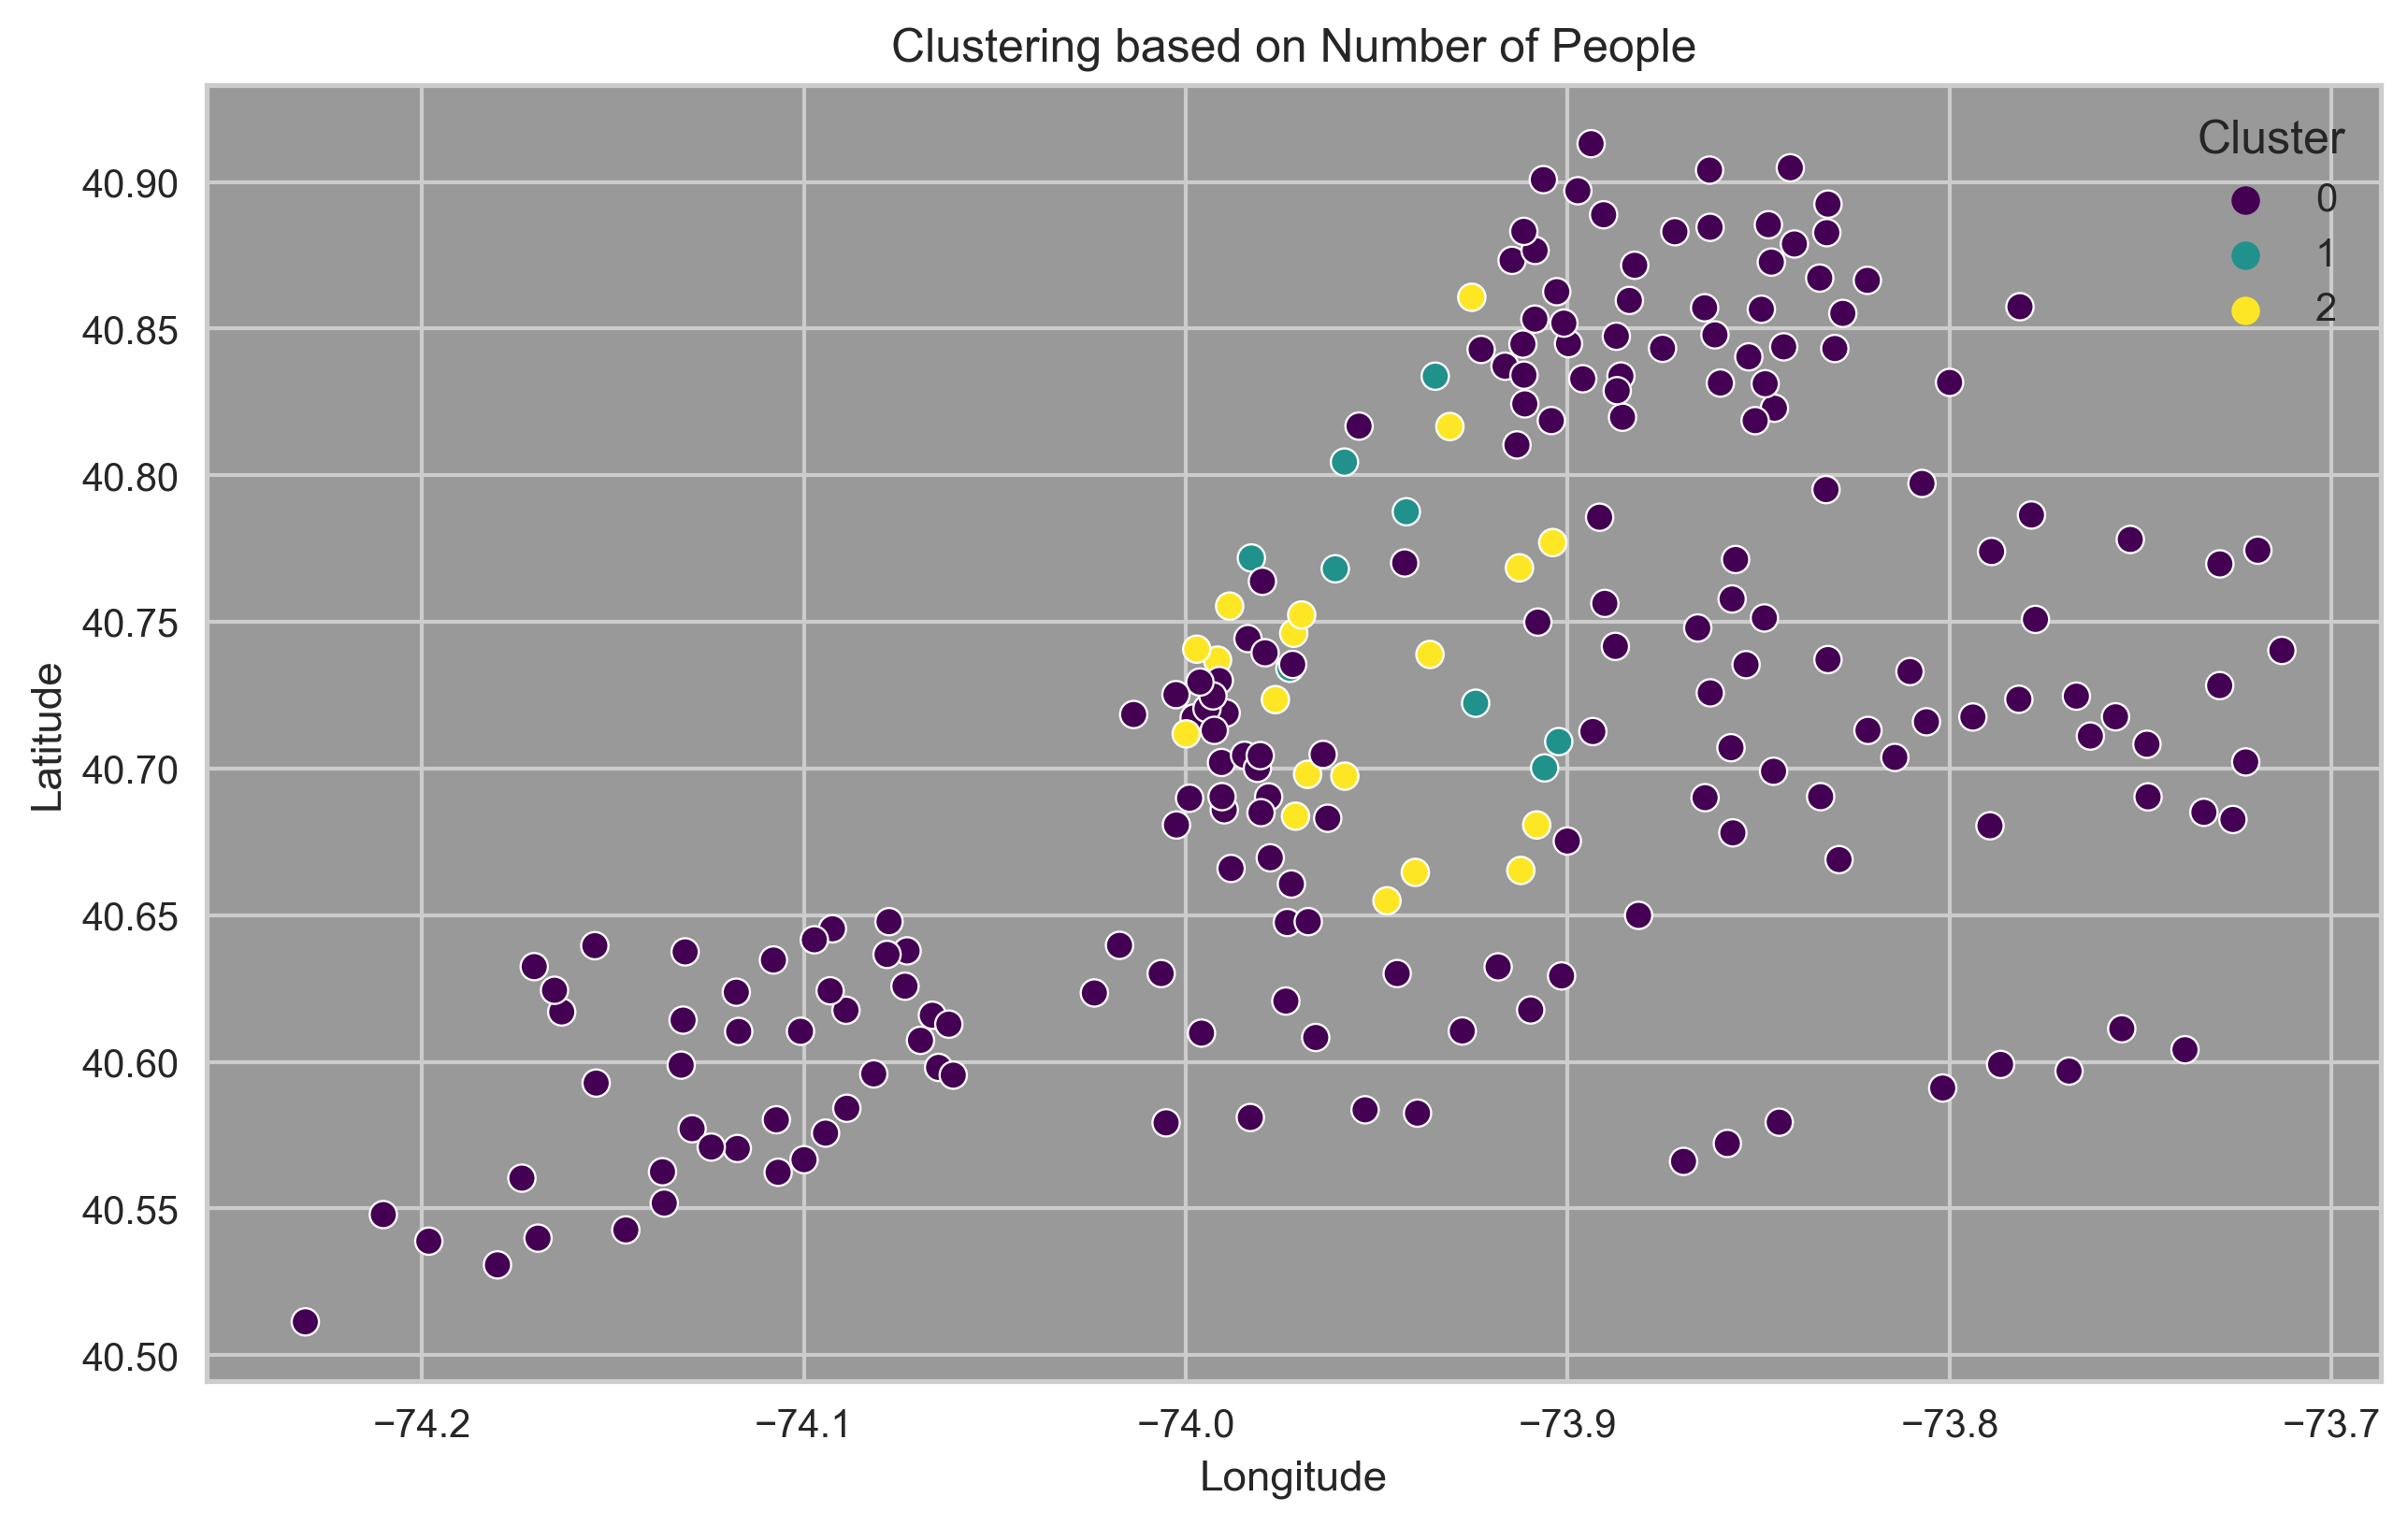

In [40]:

# Scatter plot of the clusters
sns.scatterplot(x='longitude', y='latitude', hue='Cluster', data=price, palette='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustering based on Number of People')
plt.show()

### Cluster Area by Reviews

In [51]:
reviews = df[['neighbourhood', 'reviews_per_month', 'latitude', 'longitude']]
reviews = reviews.groupby('neighbourhood').agg(reviews_per_month = ('reviews_per_month', 'sum'),
                                        latitude = ('latitude', max), longitude = ('longitude', max)).reset_index()
reviews

,neighbourhood,reviews_per_month,latitude,longitude
0,Allerton,67.86,40.87268,-73.84669
1,Arden Heights,4.16,40.56033,-74.17388
2,Arrochar,22.28,40.59809,-74.06476
3,Arverne,116.69,40.59910,-73.78665
4,Astoria,901.27,40.77705,-73.90393
...,...,...,...,...
216,Windsor Terrace,154.81,40.66063,-73.97237
217,Woodhaven,162.92,40.69907,-73.84611
218,Woodlawn,26.12,40.90406,-73.86286
219,Woodrow,0.00,40.53884,-74.19826


In [52]:

# Selecting the relevant columns for clustering
X = reviews[['reviews_per_month']].values

# Applying K-means clustering
k = 3  # Number of clusters you want to create
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Adding cluster labels to the dataframe
reviews['Cluster'] = kmeans.labels_

# Printing the resulting clusters
reviews[['neighbourhood', 'reviews_per_month', 'Cluster']]

,neighbourhood,reviews_per_month,Cluster
0,Allerton,67.86,0
1,Arden Heights,4.16,0
2,Arrochar,22.28,0
3,Arverne,116.69,0
4,Astoria,901.27,1
...,...,...,...
216,Windsor Terrace,154.81,0
217,Woodhaven,162.92,0
218,Woodlawn,26.12,0
219,Woodrow,0.00,0


* 0 cluster means less review
* 1 means moderate number of reviews
* 2 mean a lot of review

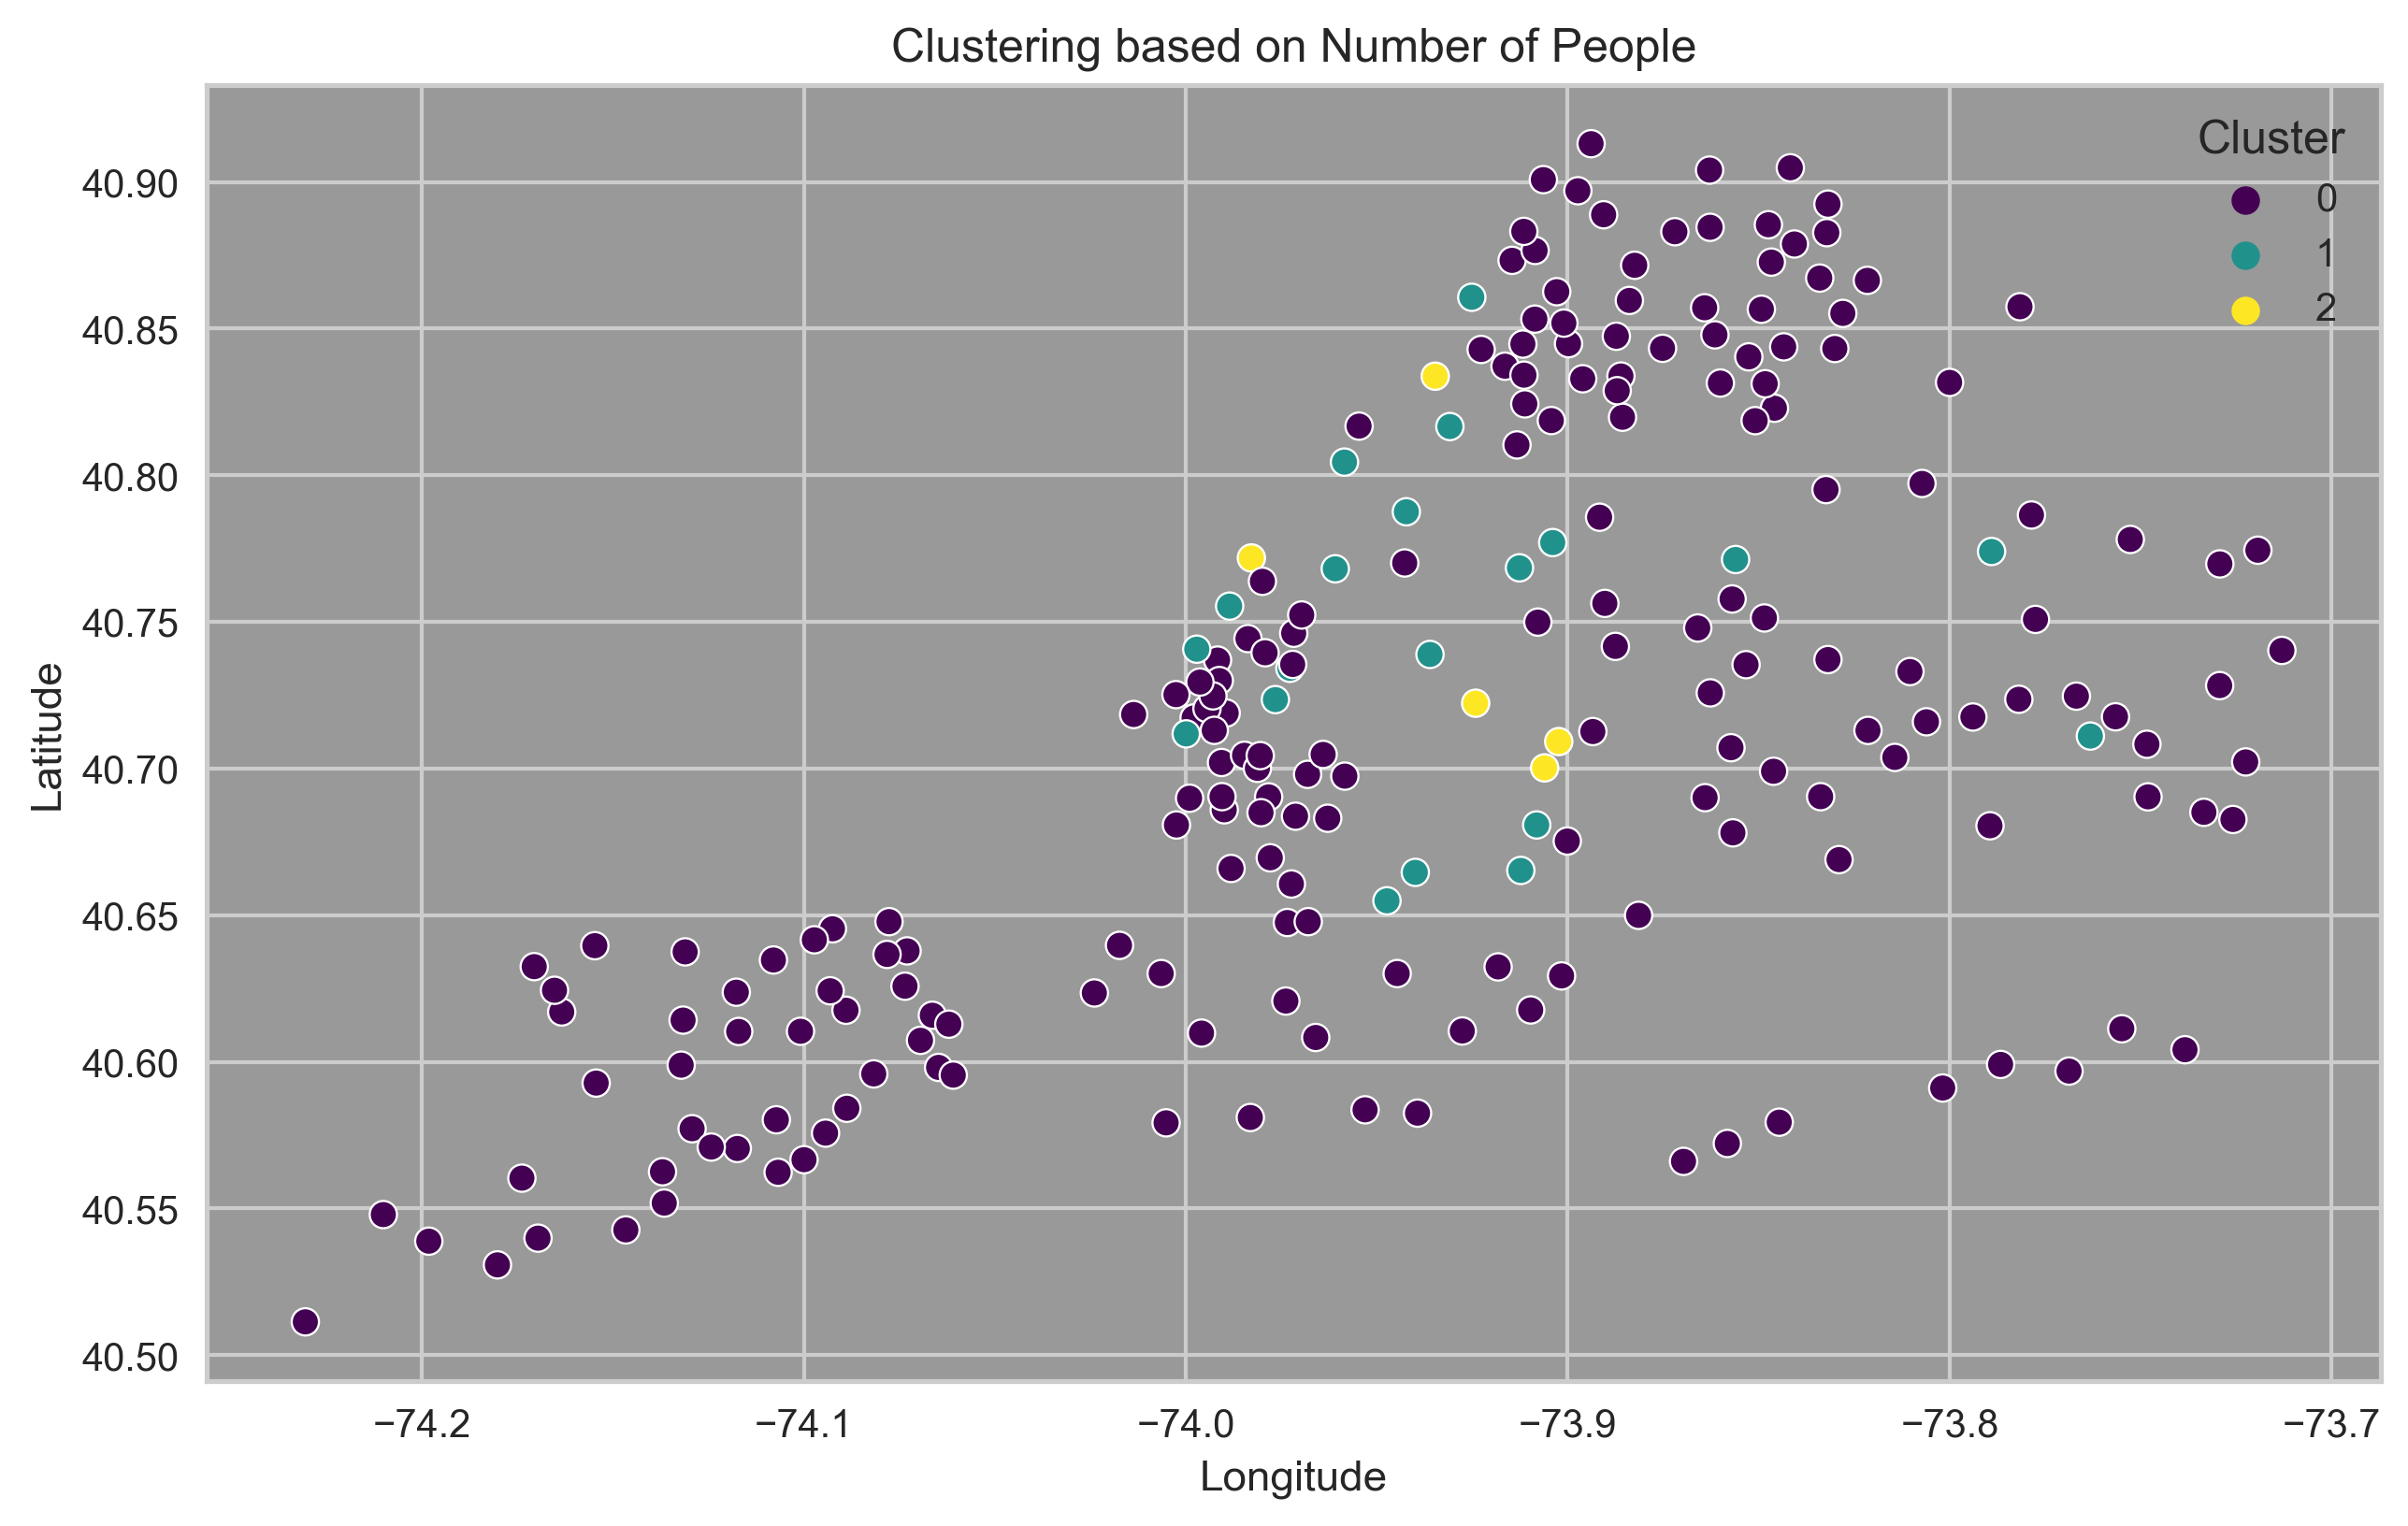

In [53]:

# Scatter plot of the clusters
sns.scatterplot(x='longitude', y='latitude', hue='Cluster', data=reviews, palette='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustering based on Number of People')
plt.show()

## Price Predicton Based on Different Features

Applying log transformation for the price column.

In [59]:
df["price"] = np.log1p(df["price"])
X = df.drop("price", axis = 1)
y = df["price"]

<h2 style="background-color:#C5F3ED;">Splitting Data as Train Data and Test Data</h2>

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

<h2 style="background-color:#C5F3ED;">Encoding</h2>

In [61]:
ohe = OneHotEncoder(handle_unknown = 'ignore')
columns = ["neighbourhood_group", "neighbourhood", "room_type"]
ohe_df_train = pd.DataFrame(ohe.fit_transform(X_train[columns]).toarray(), columns=ohe.get_feature_names())
X_train_ohe = X_train.join(ohe_df_train).drop(columns, axis=1)

ohe_df_test = pd.DataFrame(ohe.transform(X_test[columns]).toarray(), columns=ohe.get_feature_names())
X_test_ohe = X_test.join(ohe_df_test).drop(columns, axis=1)

<h2 style="background-color:#C5F3ED;">Feature Scaling</h2>

In [62]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_ohe)
X_test = scaler.transform(X_test_ohe)

# Model Building and Comparison

Our purpose is predict the price based on the given dataset. Since price is a continous variable we need to do a regression task. Therefore, we will use the Regression models of the traditional models such as Lasso Regression, Ridge Regression, Decision Tree Regressor and Random Forest Regressor.

We are not after accuracy, because we are doing a regression task, not a classification task. Our main metric will be mean squared error and we will try to minimize it with some methods such as hyperparameter tuning. 

Almost in every model we have sections such as



*   Train model with different parameters

*   See the error and train and test scores

*   Compare with other models and results






* Lasso Regression, 
* Ridge Regression, 
* Decision Tree Regressor and 
* Random Forest Regressor models will be built in the model building section.

#### Evalution Metrics

*MSE (mean squared error)*: $\frac{1}{N}\sum_i \, (y_{true_i} - y_{pred_i})^2 \,$


*RMSE (root mean squared error)*: $\sqrt{\frac{1}{N}\sum_i \, (y_{true_i} - y_{pred_i})^2}$


*MAE (mean absolute error)*: $\frac{1}{N} \sum_i \, |y_{true_i} - y_{pred_i}| \,$

Since we are measuring the errors, we want to **minimize** these metrics.

In [63]:
def models(X_train, X_test, y_train, y_test):
    
    models = pd.DataFrame(columns=["Model","Test Sc.","Train Sc.","MAE","MSE","RMSE", "RMSE CV"])
        
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    test_score = r2_score(y_test, y_pred)
    train_score = ridge.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
   
    rmse_cv = np.sqrt(-cross_val_score(ridge, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())
    
    ridge_row = {"Model": "Ridge", "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}
    
    models = models.append(ridge_row, ignore_index=True)
    
    
    
    lasso = Lasso(alpha = 0.0001)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
   
    test_score = r2_score(y_test, y_pred)
    train_score = lasso.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
   
    rmse_cv = np.sqrt(-cross_val_score(lasso, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())
    
    lasso_row = {"Model": "Lasso", "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}
    
    models = models.append(lasso_row, ignore_index=True)
    
    
    dtr = DecisionTreeRegressor(min_samples_leaf=60)
    dtr.fit(X_train, y_train)
    y_pred= dtr.predict(X_test)
   
    test_score = r2_score(y_test, y_pred)
    train_score = dtr.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    rmse_cv = np.sqrt(-cross_val_score(dtr, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())
    
    dtr_row = {"Model": "DTR", "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}
    
    models = models.append(dtr_row, ignore_index=True)
    
    
    rfr = RandomForestRegressor(random_state = 42,
                                n_estimators = 100,
                                min_samples_split = 10,
                                min_samples_leaf = 1,
                                max_features = 'sqrt',
                                max_depth = 30,
                                bootstrap = True)
    rfr.fit(X_train, y_train)
    y_pred= rfr.predict(X_test)

    test_score = r2_score(y_test, y_pred)
    train_score = rfr.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    rmse_cv = np.sqrt(-cross_val_score(rfr, X_train, y_train, scoring='neg_mean_squared_error', cv=5).mean())

    
    rfr_row = {"Model": "RFR", "Test Sc.": test_score, "Train Sc.": train_score
               ,"MAE": mae, "MSE": mse, "RMSE": rmse, "RMSE CV": rmse_cv}
    
    models = models.append(rfr_row, ignore_index=True)
    
    display(models.style.highlight_min(subset=["MAE","MSE","RMSE", "RMSE CV"], 
                                                color = 'springgreen', axis = 0).highlight_max(
        subset=["Test Sc.", "Train Sc."], color = 'springgreen', axis = 0))
    
    
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,6), dpi=300)
    plt.subplots_adjust(hspace=1.2)
    sns.lineplot(x=models["Model"], y=models["Test Sc."], ax=ax1, marker="o", color="yellow")
    sns.lineplot(x=models["Model"], y=models["Train Sc."], ax=ax2, marker="o", color="yellow")
    sns.lineplot(x=models["Model"], y=models["MAE"], ax=ax3, marker="o", color="yellow")
    sns.lineplot(x=models["Model"], y=models["MSE"], ax=ax4, marker="o", color="yellow")
    sns.lineplot(x=models["Model"], y=models["RMSE"], ax=ax5, marker="o", color="yellow")
    sns.lineplot(x=models["Model"], y=models["RMSE CV"], ax=ax6, marker="o", color="yellow")
    ax1.set_title("Test Scores Comparison", size=18)
    ax2.set_title("Train Scores Comparison", size=18)
    ax3.set_title("MAE Scores Comparison", size=18)
    ax4.set_title("MSE Scores Comparison", size=18)
    ax5.set_title("RMSE Scores Comparison", size=18)
    ax6.set_title("RMSE CV Scores Comparison", size=18)
    ax1.tick_params(labelrotation=30)
    ax2.tick_params(labelrotation=30)
    ax3.tick_params(labelrotation=30)
    ax4.tick_params(labelrotation=30)
    ax5.tick_params(labelrotation=30)
    ax6.tick_params(labelrotation=30)
    plt.show()

,Model,Test Sc.,Train Sc.,MAE,MSE,RMSE,RMSE CV
0,Ridge,0.537078,0.548551,0.058649,0.006985,0.083574,0.082121
1,Lasso,0.537465,0.548232,0.058587,0.006979,0.083539,0.082084
2,DTR,0.564116,0.608326,0.056340,0.006577,0.081096,0.080288
3,RFR,0.608500,0.762059,0.052740,0.005907,0.076857,0.076656


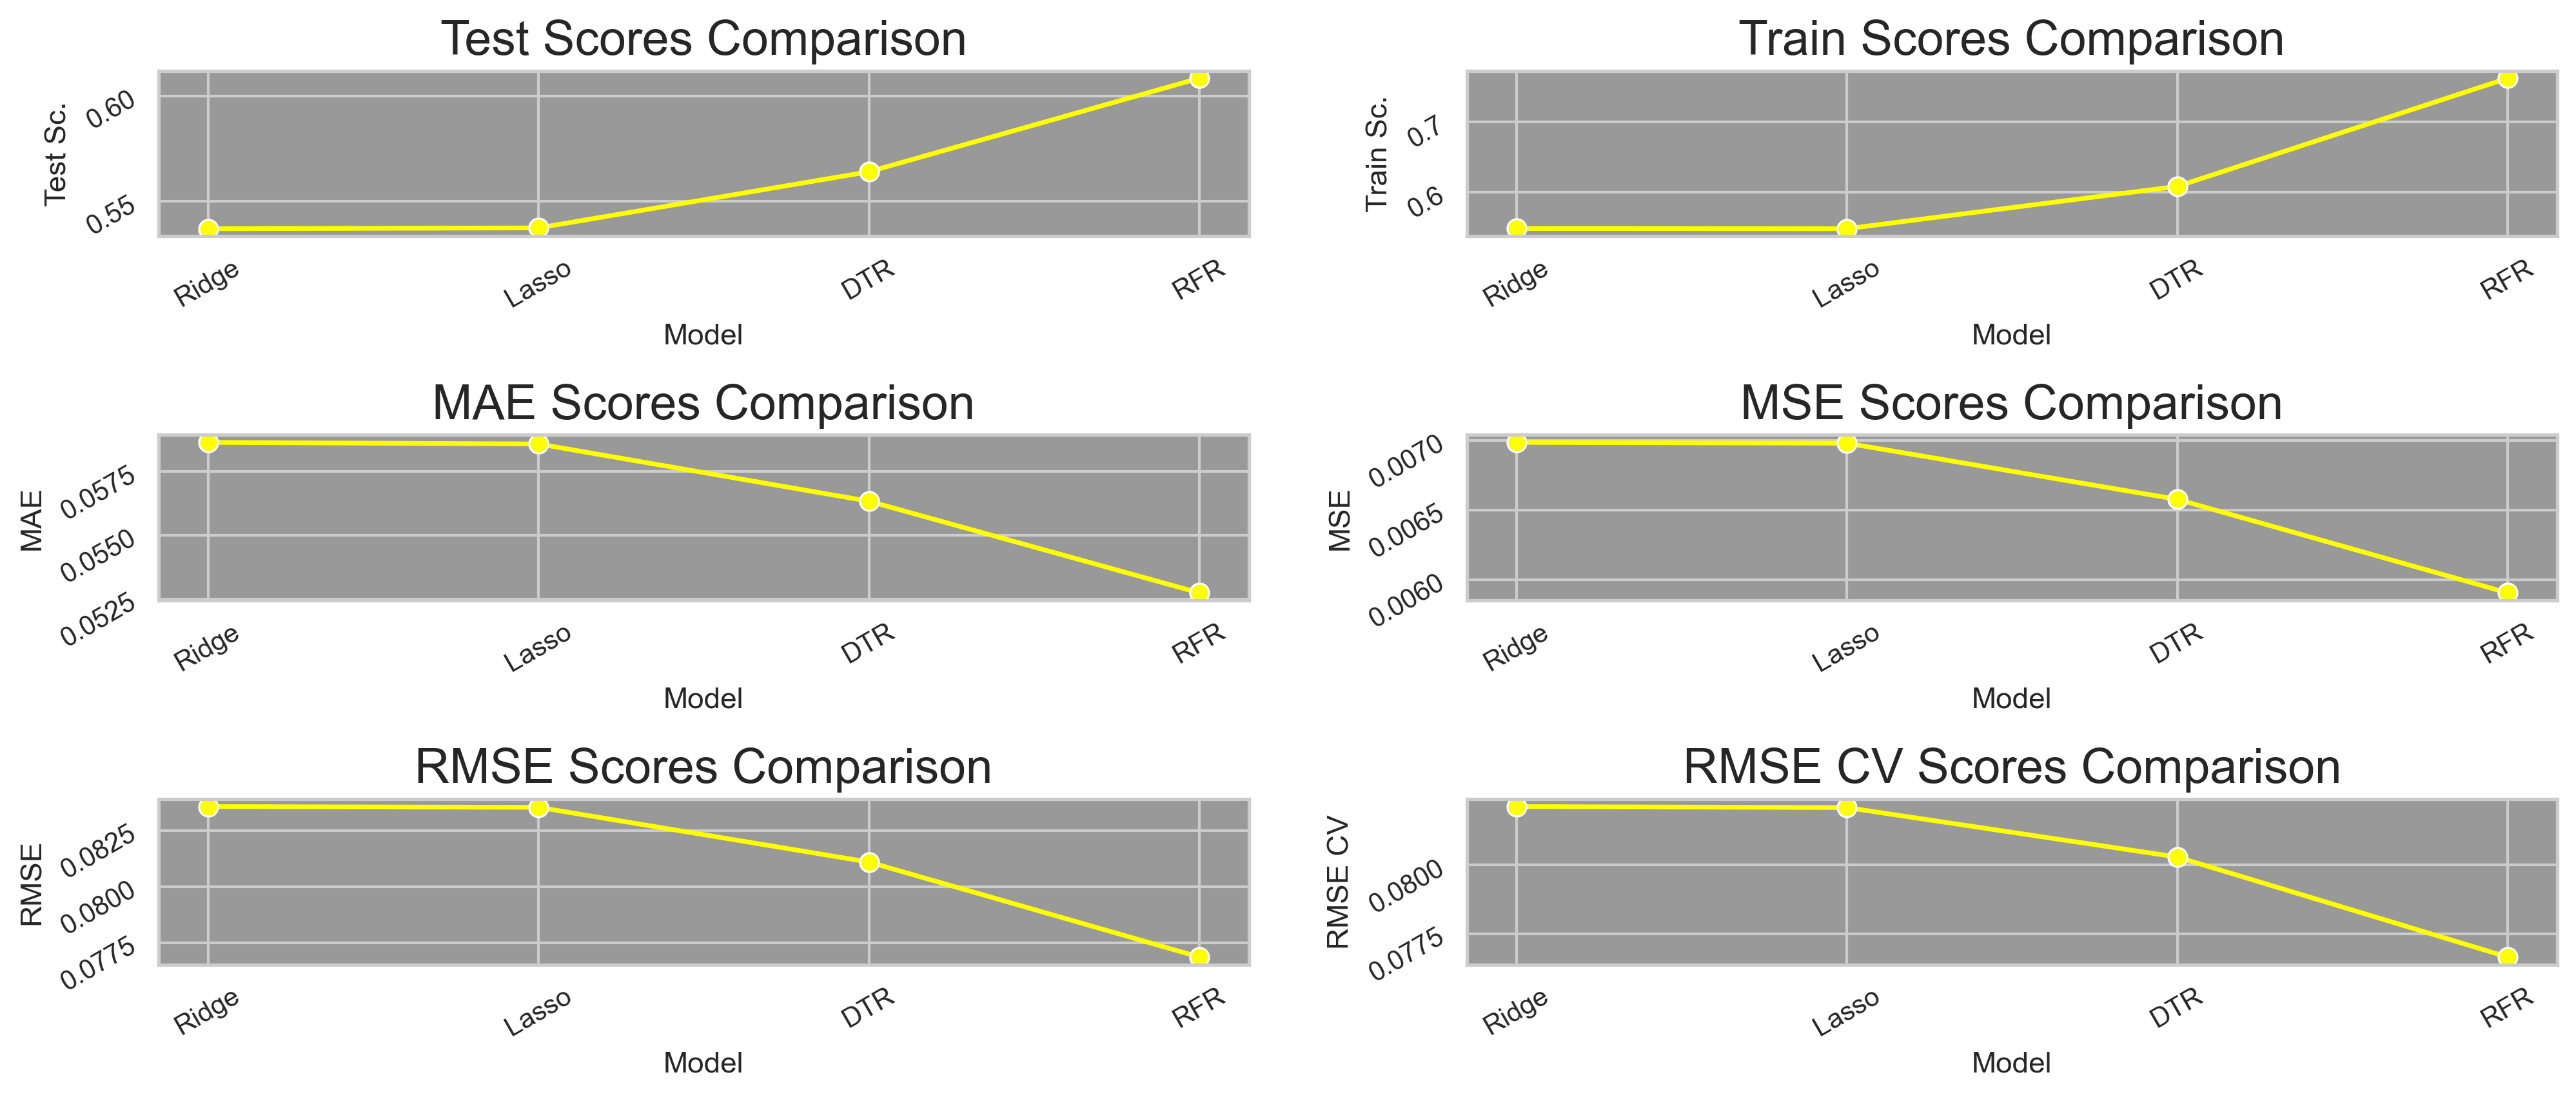

In [64]:
models(X_train, X_test, y_train, y_test)

#### RESULTS & DISCUSSION

The above tables show the Model and it's performance.
* We can see the traning and testing score of each model as well as Error score. the lesser the error is the better the model is fitted. 
* Random Forest Regressor model gives us the best Train and Test Score as well as MSE.

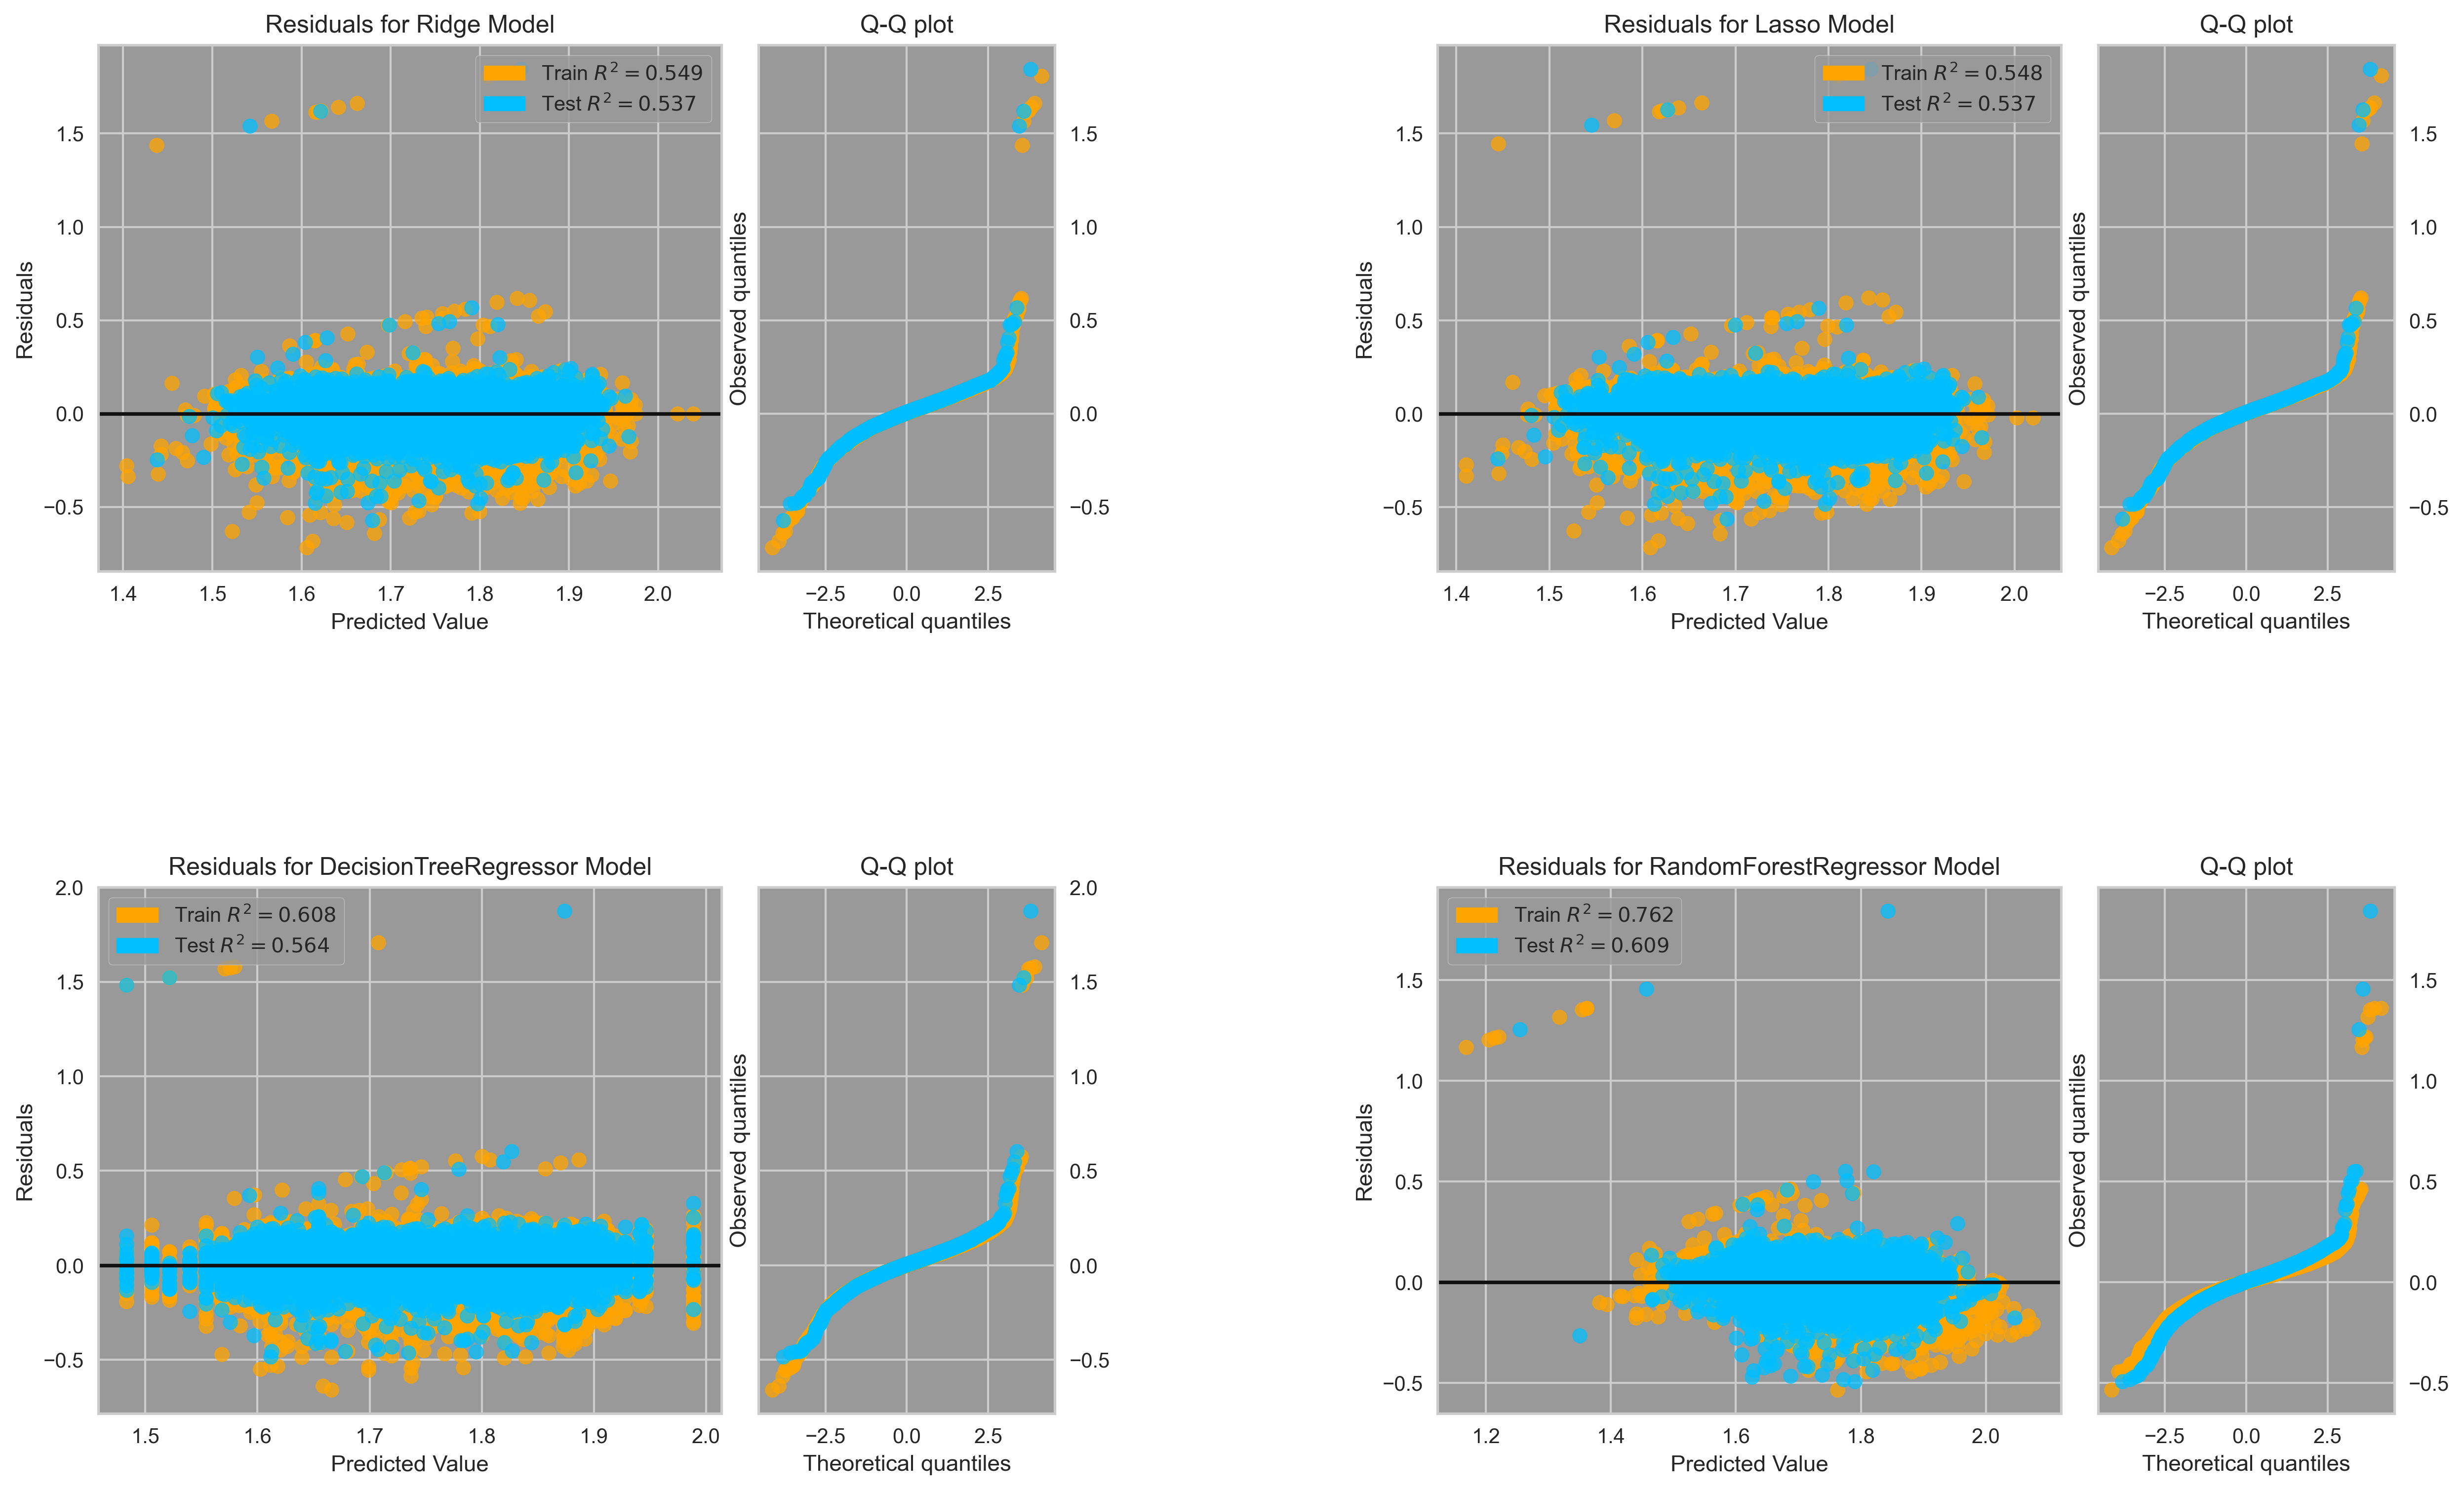

In [65]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,12), dpi=300)

fig.subplots_adjust(hspace=0.6, wspace=0.4)

ridge_visualizer = ResidualsPlot(Ridge(alpha=1.0), hist=False, qqplot=True, 
                                train_color="orange", test_color="deepskyblue", ax=ax1)



lasso_visualizer = ResidualsPlot(Lasso(alpha = 0.0001), hist=False, qqplot=True, 
                                train_color="orange", test_color="deepskyblue", ax=ax2)


dtr_visualizer = ResidualsPlot(DecisionTreeRegressor(min_samples_leaf=60), hist=False, qqplot=True, 
                                train_color="orange", test_color="deepskyblue", ax=ax3)

rfr_visualizer = ResidualsPlot(RandomForestRegressor(random_state = 42,
                                n_estimators = 100,
                                min_samples_split = 10,
                                min_samples_leaf = 1,
                                max_features = 'sqrt',
                                max_depth = 30,
                                bootstrap = True), hist=False, qqplot=True, 
                                train_color="orange", test_color="deepskyblue", ax=ax4)


ridge_visualizer.fit(X_train, y_train)
lasso_visualizer.fit(X_train, y_train)
dtr_visualizer.fit(X_train, y_train)
rfr_visualizer.fit(X_train, y_train)

ridge_visualizer.score(X_test, y_test)
lasso_visualizer.score(X_test, y_test)
dtr_visualizer.score(X_test, y_test)
rfr_visualizer.score(X_test, y_test)

ridge_visualizer.finalize()
lasso_visualizer.finalize()
dtr_visualizer.finalize()
rfr_visualizer.finalize()

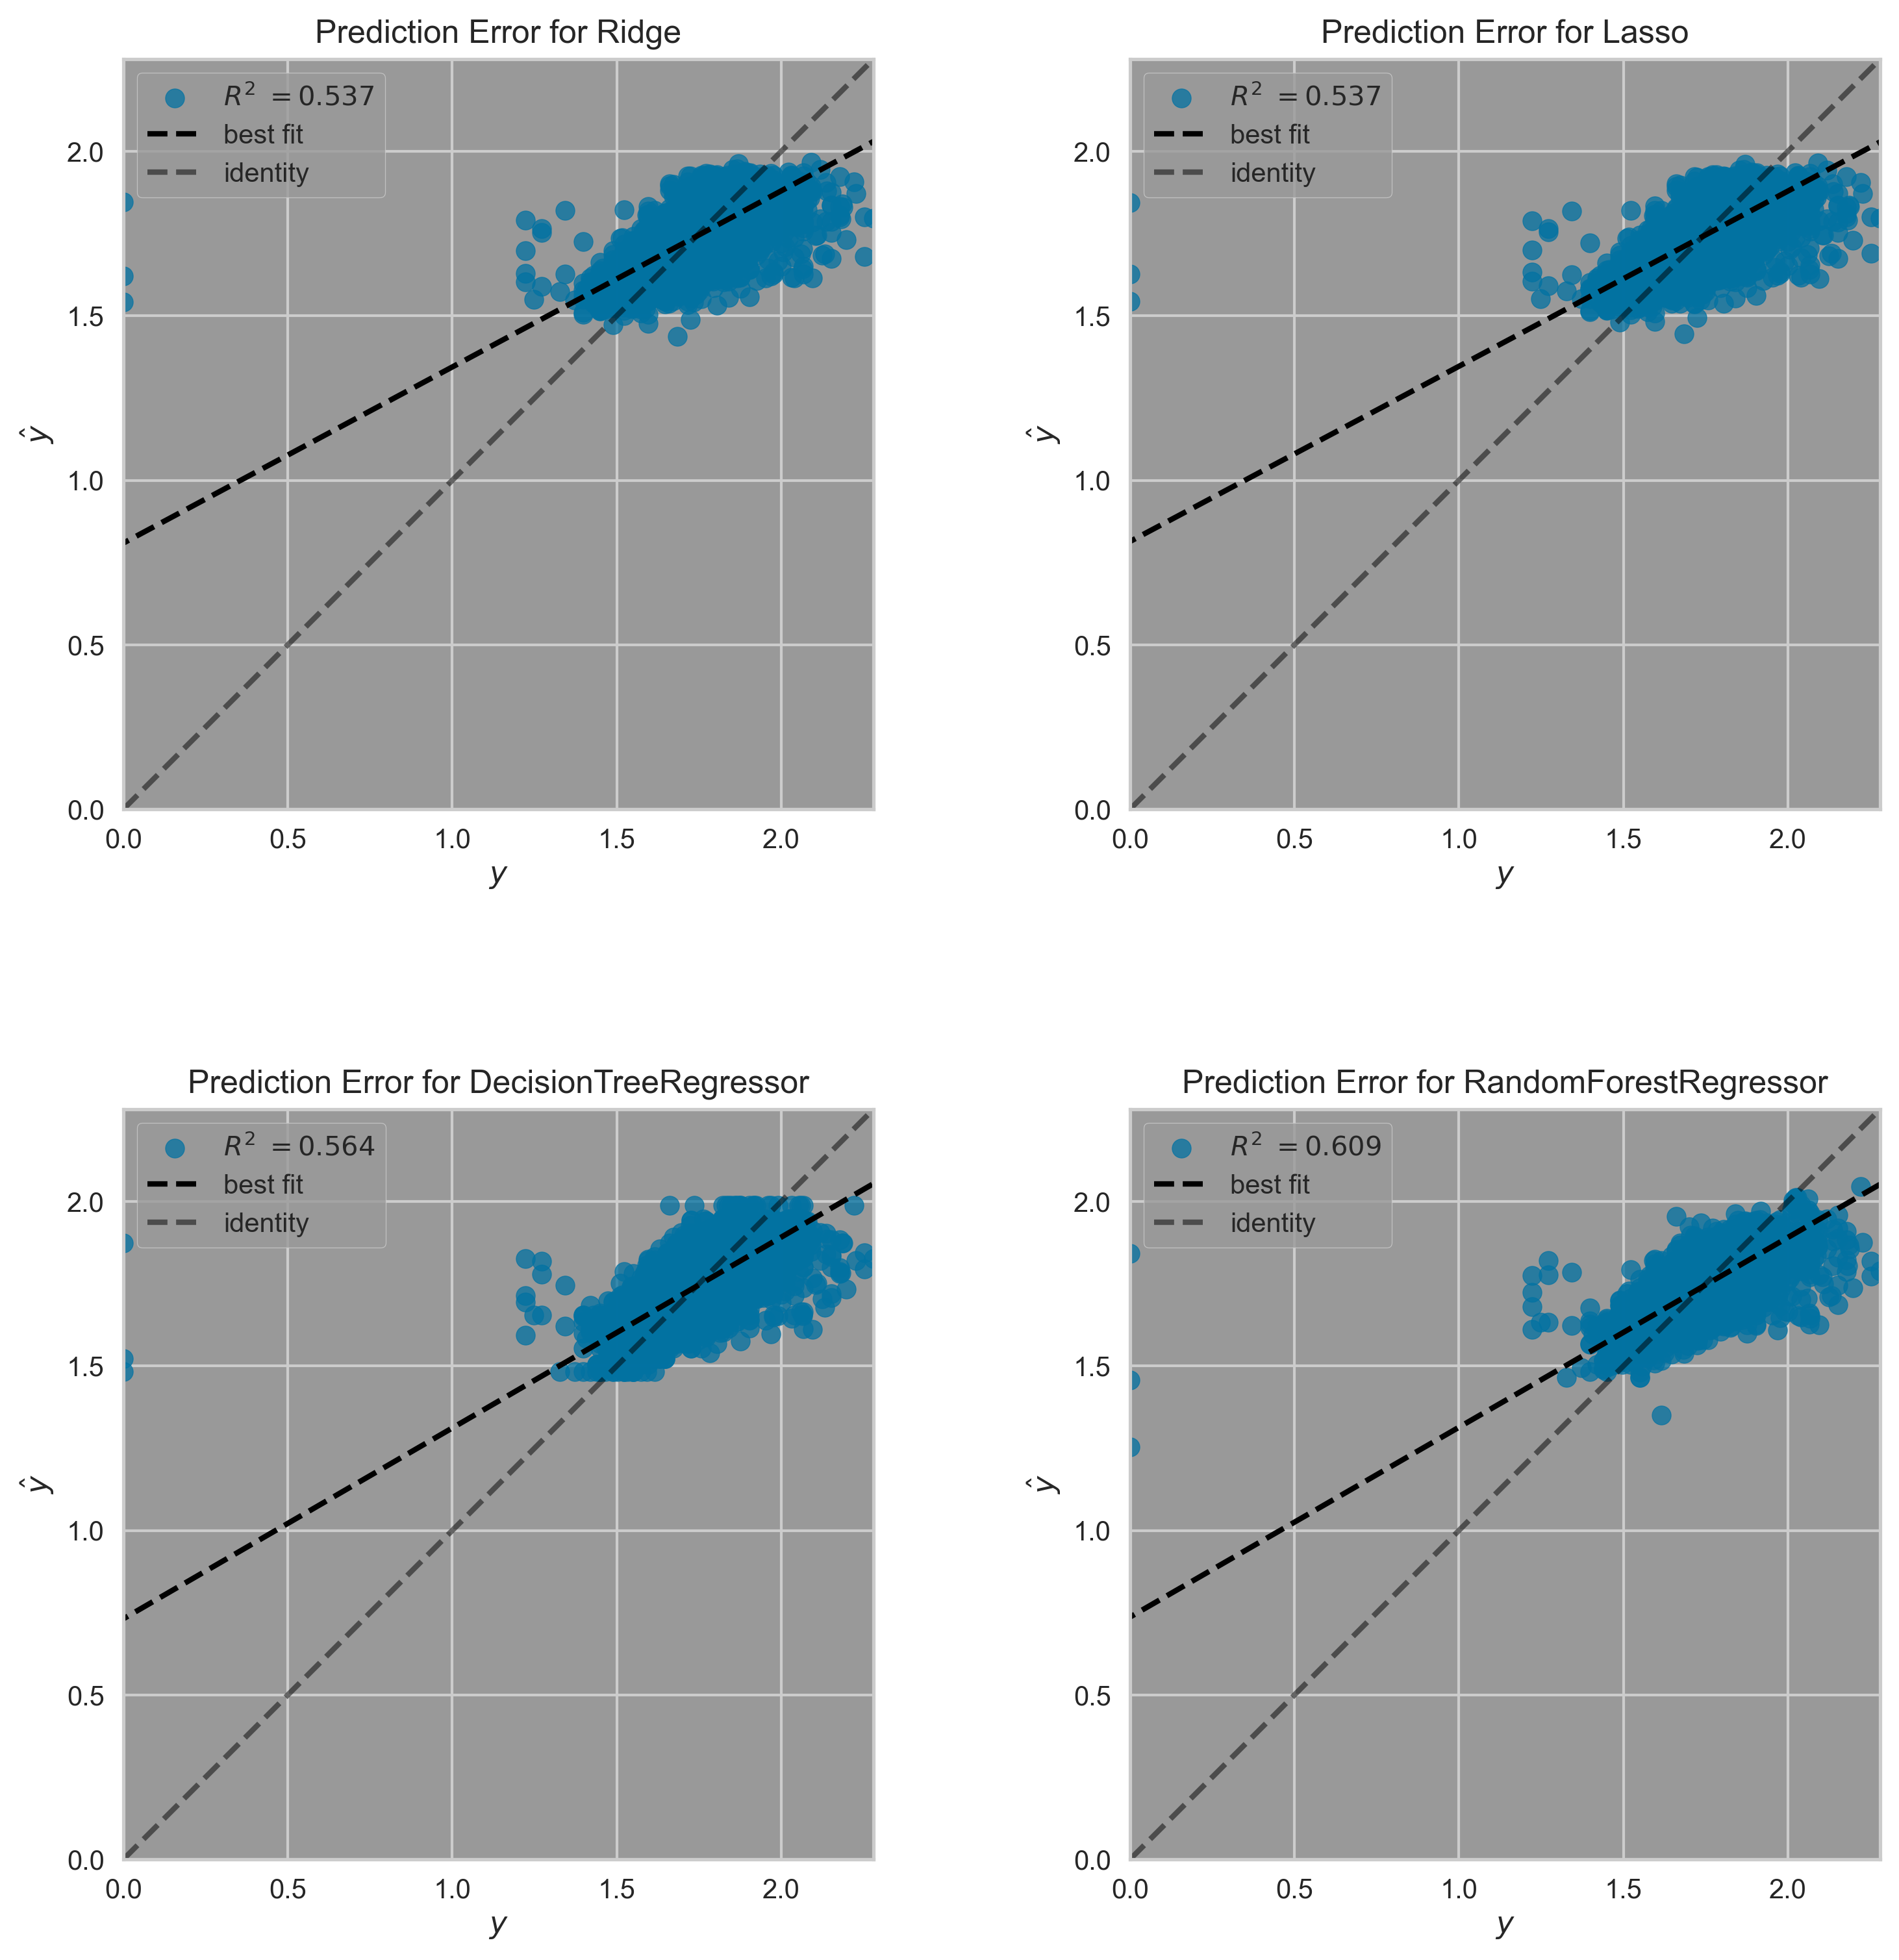

In [66]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,12), dpi=300)

fig.subplots_adjust(hspace=0.4, wspace=-0.5)

model_ridge = Ridge(alpha=1.0)

model_lasso = Lasso(alpha = 0.0001)

model_dtr = DecisionTreeRegressor(min_samples_leaf=60)

model_rfr = RandomForestRegressor(random_state = 42,
                                n_estimators = 100,
                                min_samples_split = 10,
                                min_samples_leaf = 1,
                                max_features = 'sqrt',
                                max_depth = 30,
                                bootstrap = True)

ridge_prediction_error = PredictionError(model_ridge, line_color="black", ax=ax1)
lasso_prediction_error = PredictionError(model_lasso, line_color="black", ax=ax2)
dtr_prediction_error = PredictionError(model_dtr, line_color="black", ax=ax3)
rfr_prediction_error = PredictionError(model_rfr, line_color="black", ax=ax4)

ridge_prediction_error.fit(X_train, y_train)
lasso_prediction_error.fit(X_train, y_train)
dtr_prediction_error.fit(X_train, y_train)
rfr_prediction_error.fit(X_train, y_train)

ridge_prediction_error.score(X_test, y_test) 
lasso_prediction_error.score(X_test, y_test) 
dtr_prediction_error.score(X_test, y_test) 
rfr_prediction_error.score(X_test, y_test)

ridge_prediction_error.finalize()  
lasso_prediction_error.finalize()  
dtr_prediction_error.finalize()  
rfr_prediction_error.finalize()  

* We have got Really good Accuracy using Random Forest Regressor. which is 76%. 
* We can predict prices of house by passing input features to the model. 
* In this way customer can get the idea of price based on his/her requirements. 

## WHAT CAN BE DONE TO INCREASE ACCURACY

*   There could be more data.
*   Models can be trained in lots of parameters to see which one is best. Since it took so much time, we did not train in every possible of combination.